# Mask R-CNN Annotation Tool

Tool to annotate TEM images using pre-trained Mask R-CNN model and revise annotations manually as needed.

In [1]:
# Import libraries
from tkinter import *
from PIL import Image,ImageTk
import os
import sys
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import io
from skimage import draw, io, color
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set root directory and path to trained model
ROOT_DIR = os.path.abspath("C:\\Users\\julia\\Downloads\\mask_rcnn_annotation_tool")
MODEL_DIR = os.path.join(ROOT_DIR, "mrcnn", "trained_models")

# Import Mask RCNN model
sys.path.append(ROOT_DIR)  # To find local version of the library
import mrcnn.model as modellib
from mrcnn.save import display_instances
import mrcnn.hydride_train as hydride_200x

c:\Users\julia\miniconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\julia\miniconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\julia\miniconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\julia\miniconda3\envs\mask_rcnn\lib\site-packages

## Configurations

In [10]:
config = hydride_200x.HydrideConfig()
Hydride_DIR = os.path.join(ROOT_DIR, "data")
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE=0.99
    IMAGE_MAX_DIM=1280
    NUM_CLASSES= 1 + 3 # Background + 2 flavours of hydride, and grain boundaries

config = InferenceConfig()
config.display()

dataset = hydride_200x.HydrideDataset()
class_names = ['Circumferential Hydride', 'Radial Hydride', 'Grain Boundary']


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        70
DETECTION_MIN_CONFIDENCE       0.99
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Notebook Preferences

In [5]:
# Device to load the neural network on.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
TEST_MODE = "inference"
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Model

In [6]:
warnings.filterwarnings('ignore')

os.chdir(ROOT_DIR)
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
weights_path = "samples/Irr_hydrides.h5" 

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  samples/Irr_hydrides.h5


# Set up UI

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


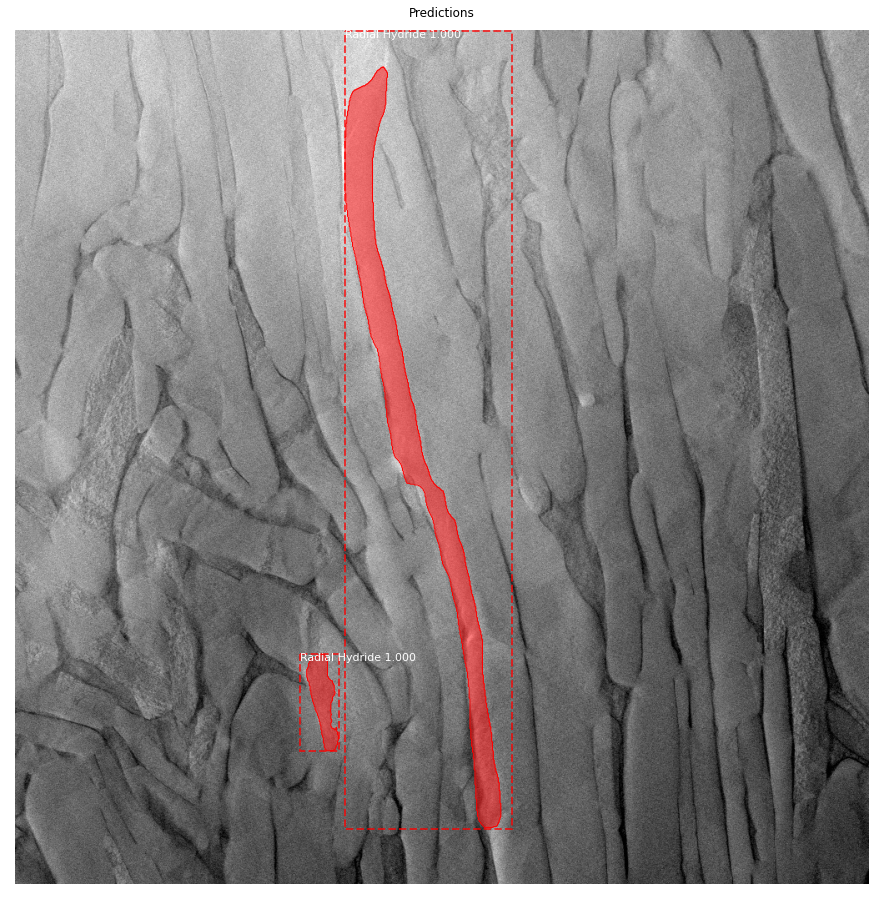

In [12]:
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox
from PIL import Image, ImageTk
import os
from csv import writer

class AnnotationTool:
    def __init__(self, master):
        self.master = master
        self.master.title("TEM Image Annotation Tool")
        self.master.geometry("500x500")
        
        self.images = []
        self.points = []
        self.instanceNum = 0 # hydride instance per image
        self.index = 0
        self.lastx = 0
        self.lasty = 0
        
        self.canvas = tk.Canvas(self.master, bg="white")
        self.canvas.pack(fill=tk.BOTH, expand=True)
        
        self.canvas.bind("<Button-1>", self.store_point)
        
        tk.Button(self.master, text="Open folder", command=self.open_folder).pack()
        tk.Button(self.master, text="Next image", command=self.next_img).pack()
        tk.Button(self.master, text="Previous image", command=self.previous_img).pack()
        tk.Button(self.master, text="Annotate with Mask R-CNN",command=self.mask_rcnn).pack()
        tk.Button(self.master,text="Revise Annotations",command=self.manual_anot).pack()
        tk.Button(self.master, text="Complete Annotation Revision",command=self.display_save).pack()
        
    def open_folder(self):
        """Open the folder containing the TEM images"""
        folder = filedialog.askdirectory()
        if not folder:
            return
        
        self.images = [Image.open(folder + "/" + f) for f in sorted(os.listdir(folder)) if f.endswith(".jpg")]
        if not self.images:
            messagebox.showerror("Error", "No JPG images found in the selected folder")
            return
        
        self.show_image()
        
    def next_img(self):
        """Move to the next image in the folder"""
        if not self.images:
            messagebox.showerror("Error", "No images to display")
            return
        
        self.index = (self.index + 1) % len(self.images)
        self.instanceNum = 0 # New image - no instances yet ** maybe move this to manual anot instead
        self.show_image()
        
    def previous_img(self):
        """Move back to the previous image in the folder"""
        if not self.images:
            messagebox.showerror("Error", "No images to display")
            return
        
        self.index = (self.index - 1 + len(self.images)) % len(self.images)
        self.show_image()
        
    def show_image(self):
        """Show the image at a given index of the specified folder"""
        
        image = self.images[self.index]
        image = image.resize((self.canvas.winfo_width(), self.canvas.winfo_height()), Image.ANTIALIAS)
        image = ImageTk.PhotoImage(image)
        self.canvas.delete("all")
        self.canvas.create_image(0, 0, image=image, anchor=tk.NW)
        self.canvas.image = image
        # Reset points array and instances for each new image
        self.points = [] # reset
        self.numInstances = 0
        
    def mask_rcnn(self):
        """Apply mask r-cnn model to annotate the specified image"""
        image = self.images[self.index]
        imgPath = image.filename
        imgName = os.path.basename(imgPath)
        # Re-open image in desired cv2 format for mask r-cnn input
        # (or convert image to 64 bit float from unsigned byte Image)
        image = io.imread(imgPath)
        subdatasetfilename = 'test/'
        save_address = '../res/' 
        try:
            results = model.detect([image], verbose=1)
            ax = get_ax(1)  
            r = results[0]
            display_instances(imgName, save_address, image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'], ax=ax,
                                title="Predictions")
            image = ImageTk.PhotoImage(Image.open(save_address + imgName).resize((self.canvas.winfo_width(), self.canvas.winfo_height()), Image.ANTIALIAS))
            self.canvas.delete("all")
            self.canvas.create_image(0, 0, image=image, anchor=tk.NW)
            self.canvas.image = image
        
        except Exception as e:
            print("error") 
            print(e) 
            messagebox.showerror("Error", "Could not run Mask R-CNN")
            return
    
    def store_point(self,event):
        """Stores location clicked with mouse as (x,y) point and draws lines
        between points"""
        
        if len(self.points) != 0:
            # Draw line if more than one point
            self.canvas.create_line((self.lastx, self.lasty, event.x, event.y))
        else:
            # New instance - append the image name and hydride instance 
            # number to points array
            self.points.append(os.path.basename(self.images[self.index].filename))
            self.points.append(self.instanceNum)
            self.instanceNum += 1
        # Store
        self.lastx, self.lasty = event.x, event.y
        self.points.append(event.x)
        self.points.append(event.y)

    def display_save(self): 
        """Displays the polygonal annotation once user has finished
        drawing, and saves the list of points for each instance in 
        format [instanceNum, x1, y1, x2, y2, x2, y3 ...]"""
        
        self.canvas.create_polygon(self.points[2:], outline='#f11',fill='', width=2)
        
        # Write to csv
        outputCSV = open('manual_hydride_anotations.csv', 'a')
        if not outputCSV:
            messagebox.showerror("Error", "No file to save new annotations")
            return
        writer_object = writer(outputCSV)
        writer_object.writerow(self.points)
        outputCSV.close() # TODO - fix issue with file locking
        self.points = [] # reset
        
    def manual_anot(self):
        """Swaps mask r-cnn annotated image for original if user would like to
        edit"""
        self.show_image()

        
root = tk.Tk()
app = AnnotationTool(root)
root.mainloop()

### Run detection on all images in a folder

In [ ]:
# Read all images in a folder

subdatasetfilename = 'JEtest/'

save_address = '../results/' 
i=0
for filename in os.listdir(r'data/'+subdatasetfilename):
    i = i + 1
    if filename.endswith('.jpg'): # Could be .jpeg
      print(filename)
      
      image = io.imread("data/" + subdatasetfilename + filename)

      try:
          results = model.detect([image], verbose=1)
          ax = get_ax(1)  
          r = results[0]
          save.display_instances(filename, save_address, image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions") 
      except Exception as e:
        print("error") 
        print(e) 
        pass